In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mne.io import RawArray
from mne import create_info
from scipy import signal

In [2]:
def plot_sources(sources):
    info_m = create_info(sources.shape[0], 1000, 'misc')
    raw_m = RawArray(sources, info_m)
    fig = raw_m.plot(n_channels=10)

## Small dataset

In [3]:
data = np.load('small_sample_2.npy')

In [4]:
info_m = create_info(data.shape[0], 1000, 'misc')
info_e = create_info(data.shape[0], 1000, 'eeg')

In [5]:
raw_m = RawArray(data, info_m)
raw_e = RawArray(data, info_e)

Creating RawArray with float64 data, n_channels=82, n_times=300000
    Range : 0 ... 299999 =      0.000 ...   299.999 secs
Ready.
Creating RawArray with float64 data, n_channels=82, n_times=300000
    Range : 0 ... 299999 =      0.000 ...   299.999 secs
Ready.


In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


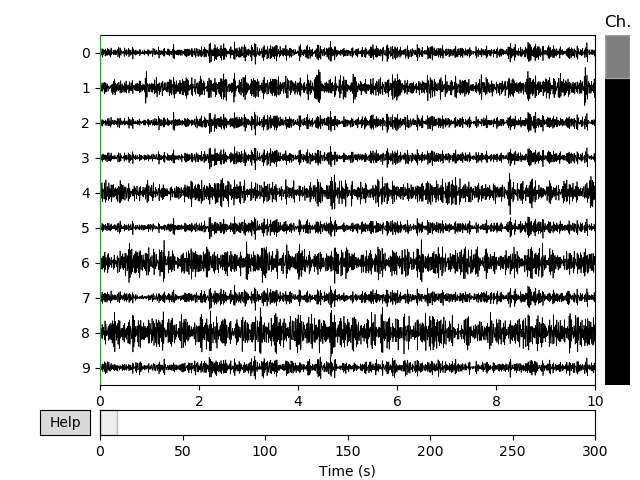

In [7]:
fig = raw_m.plot(n_channels=10)

In [8]:
from mne.preprocessing import ICA

In [99]:
ica2 = ICA(max_pca_components=None, n_pca_components=None, n_components=5, method='picard')

In [100]:
ica2.fit(raw_e, picks='all')

Fitting ICA to data using 82 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 7.6s.


<ICA  |  raw data decomposition, fit (picard): 300000 samples, 5 components, channels used: "eeg">

In [101]:
ics2 = ica2.get_sources(raw_m.load_data())._data

In [89]:
ica3 = ICA(max_pca_components=None, n_pca_components=None, n_components=4, method='picard')

In [90]:
ica3.fit(raw_e, picks='all')

Fitting ICA to data using 82 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 26.0s.


<ICA  |  raw data decomposition, fit (picard): 300000 samples, 4 components, channels used: "eeg">

In [91]:
ics3 = ica3.get_sources(raw_m.load_data())._data

In [73]:
def cosine_dist(A,B):
    M = np.empty((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            M[i][j] = np.dot(A[i], B[j]) / (np.linalg.norm(A[i]) * np.linalg.norm(B[j]))
    return(M)

<IPython.core.display.Javascript object>


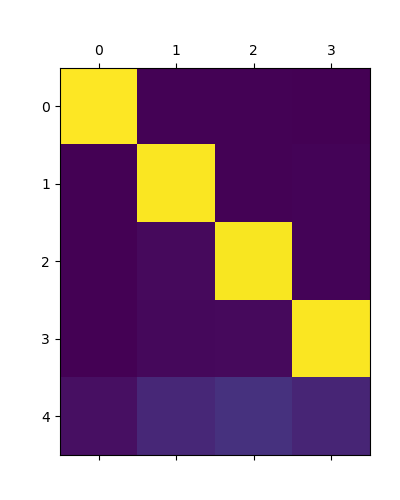

In [102]:
plt.matshow(np.abs(cosine_dist(ics2, ics3)))

In [103]:
weights = np.transpose(ica2.get_components())

<IPython.core.display.Javascript object>


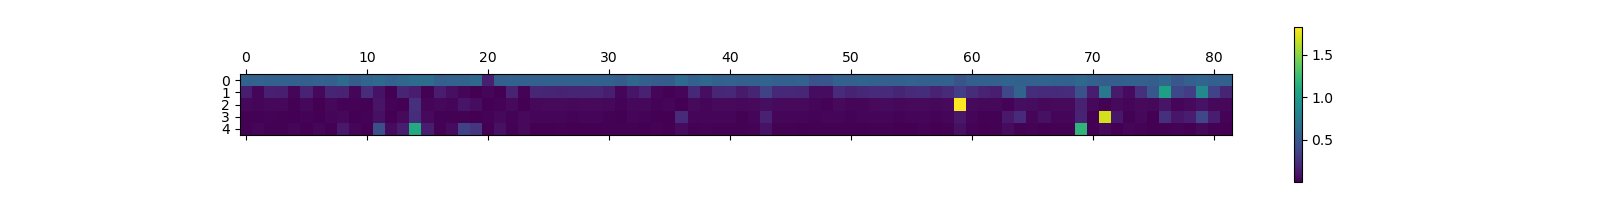

In [104]:
plt.matshow(np.abs(weights))
plt.colorbar()

In [62]:
%matplotlib inline

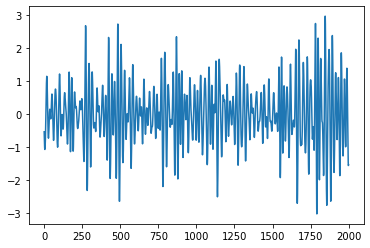

In [134]:
plt.plot(ics10[0][10000:12000])

Creating RawArray with float64 data, n_channels=3, n_times=300000
    Range : 0 ... 299999 =      0.000 ...   299.999 secs
Ready.


<IPython.core.display.Javascript object>


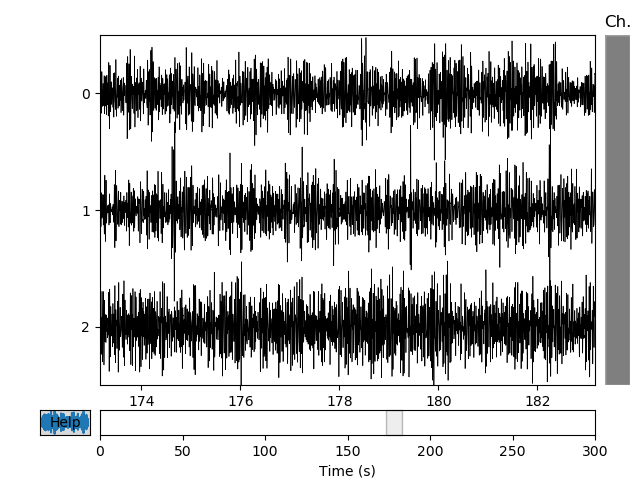

In [14]:
plot_sources(ics3)

In [138]:
np.mean(weights, axis=1)

array([ 0.55664865, -0.06604019, -0.05114101,  0.02464724,  0.03403335,
        0.00839939, -0.01823148, -0.01972085, -0.00585764, -0.02367766,
        0.05947169,  0.03748706,  0.00211303, -0.00724855,  0.01667108,
       -0.01492593, -0.02262039, -0.00625206, -0.03645415,  0.03381352])

In [63]:
reconst_raw_1 = raw_e.copy()
ica3.apply(reconst_raw_1, exclude=[0])
reconst_raw_2 = raw_e.copy()
ica3.apply(reconst_raw_2, exclude=[0,1])
reconst_raw_3 = raw_e.copy()
ica3.apply(reconst_raw_3, exclude=[0,1,8])

Transforming to ICA space (11 components)
Zeroing out 1 ICA components
Transforming to ICA space (11 components)
Zeroing out 2 ICA components
Transforming to ICA space (11 components)
Zeroing out 3 ICA components


<RawArray  |  None, n_channels x n_times : 82 x 300000 (300.0 sec), ~187.8 MB, data loaded>

In [64]:
reconst_1 = reconst_raw_1._data
reconst_2 = reconst_raw_2._data
reconst_3 = reconst_raw_3._data

In [65]:
%matplotlib notebook
from matplotlib.widgets import Slider

<IPython.core.display.Javascript object>


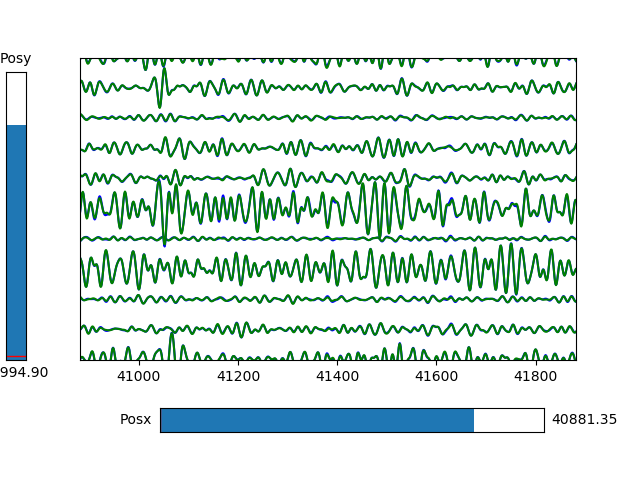

In [66]:
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

m = 19
minRange = 0
maxRange = 1000
offset = 500
numPlots = 82
xrange = 50000

diff = maxRange - minRange

plt.yticks([], [])

for i in range(numPlots):
    #plt.plot(data[i][0:xrange] + offset*i, 'k')
    #plt.plot(reconst_1[i][0:xrange] + offset*i, 'r')
    plt.plot(reconst_2[i][0:xrange] + offset*i, 'b')
    plt.plot(reconst_3[i][0:xrange] + offset*i, 'g')
    

plt.axis([minRange, maxRange, -offset, (10-1)*offset])

axposy = plt.axes([0.01, 0.25, 0.03, 0.60])
axposx = plt.axes([0.25, 0.1, 0.60, 0.05])

sposy = Slider(axposy, 'Posy', -offset, (numPlots-1)*offset, orientation='vertical')
sposx = Slider(axposx, 'Posx', 0, xrange, orientation='horizontal')

def update(val):
    posy = sposy.val
    posx = sposx.val
    #posx = 0
    ax.axis([posx,posx+diff,posy,posy+10*offset])
    fig.canvas.draw_idle()

sposy.on_changed(update)
sposx.on_changed(update)

plt.show()

Looks like this method is iterative (I think). I guess this because the components of a single run can (but not necessarily) be correlated. I would assume any simultaneous method would have no correlation but idk. MNE takes first n pca components and does ica on those; it returns those components plus all kept pca components. I'll have to keep thinking, if it's iterative, wouldn't the first few components always be the same?

## Simulated

In [87]:
def make_rand_signal(X):
    sig = np.zeros(len(X))
    for i in range(10):
        sig = sig + np.random.rand()*np.sin(np.random.rand()*X) + np.random.rand()*np.cos(np.random.rand()*X)
    return sig

In [155]:
#Generate data
S = []
X = np.arange(10,1010,0.1)
for i in range(5):
    S.append(make_rand_signal(X))

Y = []
for i in range(20):
    temp = make_rand_signal(X)
    for j in range(5):
        temp = temp + 10*np.random.rand()*S[j]
    Y.append(temp)

Y = np.array(Y)

In [278]:
np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 16, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = []
for i in range(20):
    A.append([3.*np.random.rand(),3.*np.random.rand(),3.*np.random.rand()])
A = np.array(A)
#A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0], [2,1,0], [2.2,1.1,1.4],[3,0.2,4], [2.4,1.7,2.2]])  # Mixing matrix
Y = np.dot(S, A.T)  # Generate observations
Y = np.transpose(Y)

In [279]:
%matplotlib inline

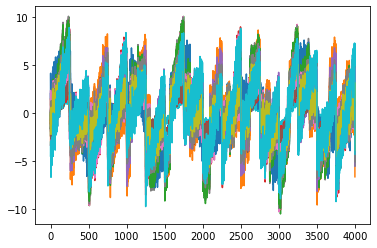

In [280]:
for i in Y:
    plt.plot(i)

In [281]:
info_m = create_info(Y.shape[0], 1000, 'misc')
info_e = create_info(Y.shape[0], 1000, 'eeg')

In [282]:
raw_m = RawArray(Y, info_m)
raw_e = RawArray(Y, info_e)

Creating RawArray with float64 data, n_channels=20, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.
Creating RawArray with float64 data, n_channels=20, n_times=4000
    Range : 0 ... 3999 =      0.000 ...     3.999 secs
Ready.


In [283]:
%matplotlib notebook

<IPython.core.display.Javascript object>


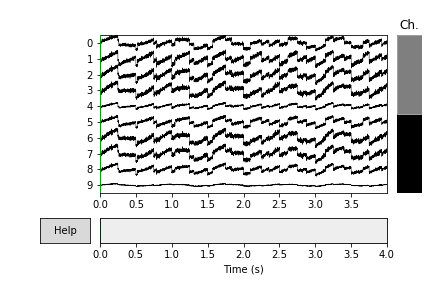

<IPython.core.display.Javascript object>


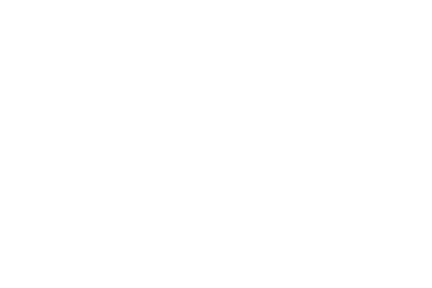

In [284]:
fig = raw_m.plot(n_channels=10)

In [285]:
def cosine_dist(A,B):
    M = np.empty((A.shape[0], B.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            M[i][j] = np.dot(A[i], B[j]) / (np.linalg.norm(A[i]) * np.linalg.norm(B[j]))
    return(M)

In [286]:
from mne.preprocessing import ICA

In [287]:
ica1 = ICA(max_pca_components=None, n_components=1, method='picard')
ica2 = ICA(max_pca_components=None, n_components=2, method='picard')
ica3 = ICA(max_pca_components=None, n_components=3, method='picard')
ica4 = ICA(max_pca_components=None, n_components=4, method='picard')
ica5 = ICA(max_pca_components=None, n_components=5, method='picard')
ica6 = ICA(max_pca_components=None, n_components=6, method='picard')
ica7 = ICA(max_pca_components=None, n_components=7, method='picard')

In [288]:
ica1.fit(raw_e, picks='all')
ica2.fit(raw_e, picks='all')
ica3.fit(raw_e, picks='all')
ica4.fit(raw_e, picks='all')
ica5.fit(raw_e, picks='all')
ica6.fit(raw_e, picks='all')
ica7.fit(raw_e, picks='all')

Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 1 components
Fitting ICA took 0.0s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 2 components
Fitting ICA took 0.0s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 0.0s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 4 components
Fitting ICA took 0.0s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 5 components
Fitting ICA took 0.1s.
Fitting ICA to data using 20 channels (please be patient, this may take a while)
Inferring max_pca_components 

<ICA  |  raw data decomposition, fit (picard): 4000 samples, 7 components, channels used: "eeg">

In [289]:
data1 = ica1.get_sources(raw_m.load_data())._data
data2 = ica2.get_sources(raw_m.load_data())._data
data3 = ica3.get_sources(raw_m.load_data())._data
data4 = ica4.get_sources(raw_m.load_data())._data
data5 = ica5.get_sources(raw_m.load_data())._data
data6 = ica6.get_sources(raw_m.load_data())._data
data7 = ica7.get_sources(raw_m.load_data())._data

In [290]:
%matplotlib inline

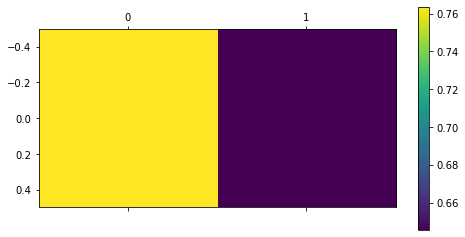

In [291]:
plt.matshow(np.abs(cosine_dist(data1, data2)))
plt.colorbar()

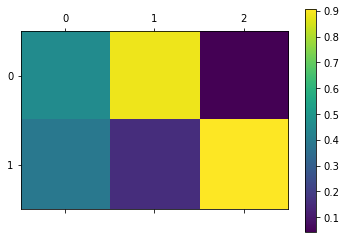

In [292]:
plt.matshow(np.abs(cosine_dist(data2, data3)))
plt.colorbar()

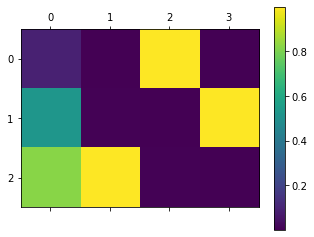

In [293]:
plt.matshow(np.abs(cosine_dist(data3, data4)))
plt.colorbar()

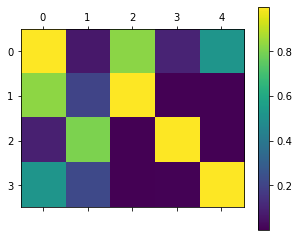

In [294]:
plt.matshow(np.abs(cosine_dist(data4, data5)))
plt.colorbar()

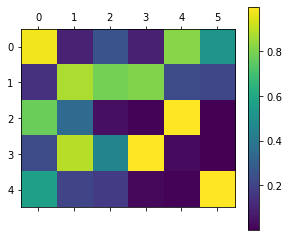

In [295]:
plt.matshow(np.abs(cosine_dist(data5, data6)))
plt.colorbar()

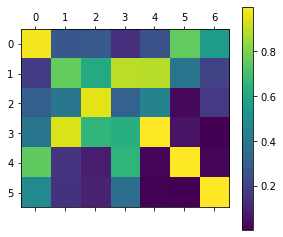

In [311]:
plt.matshow(np.abs(cosine_dist(data6, data7)))
plt.colorbar()

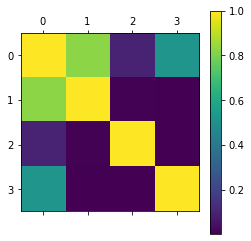

In [297]:
plt.matshow(np.abs(cosine_dist(data4, data4)))
plt.colorbar()

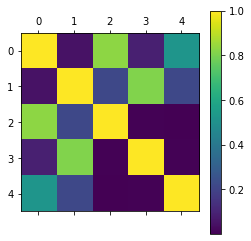

In [298]:
plt.matshow(np.abs(cosine_dist(data5, data5)))
plt.colorbar()

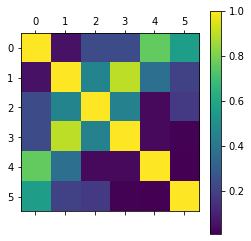

In [299]:
plt.matshow(np.abs(cosine_dist(data6, data6)))
plt.colorbar()

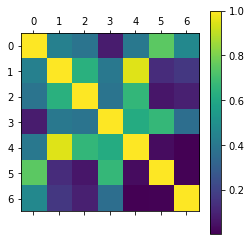

In [300]:
plt.matshow(np.abs(cosine_dist(data7, data7)))
plt.colorbar()